In [1]:
%matplotlib inline
import numpy as np
import time
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import pyFAI
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 0.21.3


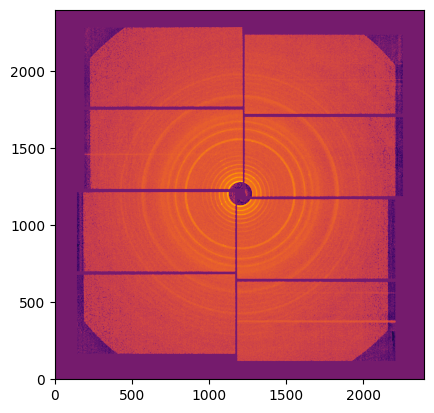

In [37]:
# In this example, we will re-use one of the image used int the test-suite
# filename = UtilsTest.getimage("Pilatus1M.edf")
# frame = fabio.open(filename).data
frame = np.load("AgBh.npy")
# and now display the image
ax = jupyter.display(frame)

In [38]:
# This allow to measure approximatively the position of the beam center ...
x = 1200 # x-coordinate of the beam-center in pixels
y = 1200 # y-coordinate of the beam-center in pixels
d = 79 # This is the distance in mm (unit used by Fit2d)
wl = 1.03e-10 # The wavelength is 1 Å

In [39]:
# Definition of the detector and of the calibrant:
# pilatus = pyFAI.detector_factory("Pilatus1M")
Pixel1 = 50e-6
Pixel2 = 50e-6
detector = pyFAI.detectors.Detector(pixel1=Pixel1, pixel2=Pixel2, max_shape=[2399,2399]) 

behenate = CALIBRANT_FACTORY("AgBh")
behenate.wavelength = wl
behenate

AgBh Calibrant with 49 reflections at wavelength 1.03e-10

In [41]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=detector, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.030000e-10m
SampleDetDist= 7.900000e-02m	PONI= 6.000000e-02, 6.000000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 79.000mm	Center: x=1200.000, y=1200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [42]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", frame, calibrant=behenate, detector=detector, geometry=initial)
sg.extract_cp(max_rings=7)

ControlPoints instance containing 7 group of point:
AgBh Calibrant with 49 reflections at wavelength 1.03e-10
Containing 7 groups of points:
# j ring 0: 12 points
# k ring 1: 316 points
# l ring 2: 111 points
# m ring 3: 166 points
# n ring 4: 240 points
# o ring 5: 361 points
# p ring 6: 361 points

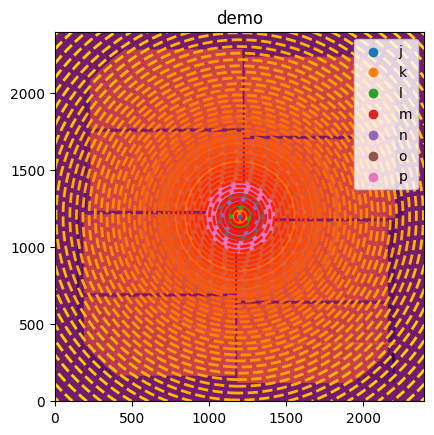

In [43]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
ax = jupyter.display(sg=sg)

In [44]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.030000e-10m
SampleDetDist= 7.721097e-02m	PONI= 6.002552e-02, 5.999651e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 77.211mm	Center: x=1199.930, y=1200.510 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

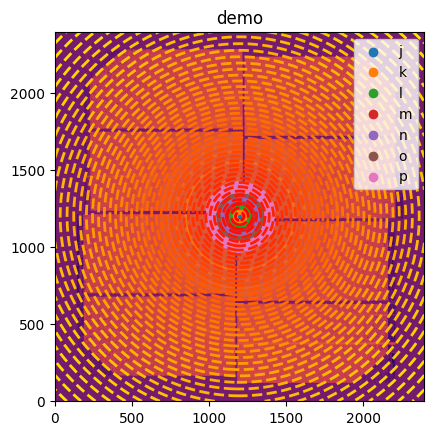

In [45]:
ax = jupyter.display(sg=sg)

In [46]:
#Save the geometry obtained
sg.geometry_refinement.save("geometry.poni")
with open("geometry.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Fri Oct 28 20:02:54 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.9980409862646353
Poni1: 0.059972878239300184
Poni2: 0.06001884449767348
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1.03e-10
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Fri Oct 28 20:07:29 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.07701629218810248
Poni1: 0.06002152473554341
Poni2: 0.060002702127747665
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1.03e-10
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Fri Oct 28 20:18:31 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.07721096973701619
Poni1: 0.06002551947597375
Poni2: 0.0599965084

(0.0, 15.0)

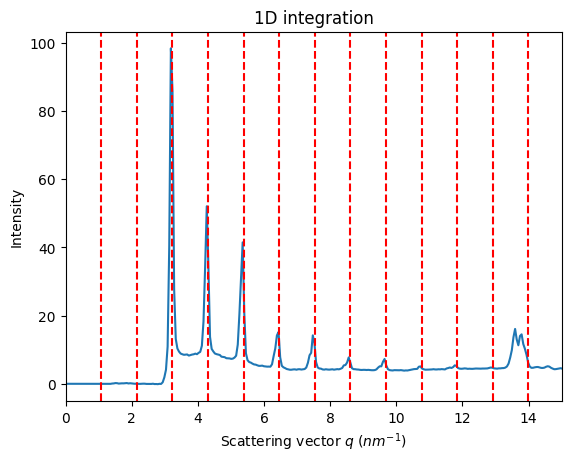

In [48]:
#Use the geometry to perform an azimuthal integration
ai = sg.get_ai()
res = ai.integrate1d(frame, 1000)
ax = jupyter.plot1d(res,calibrant=behenate)
ax.set_xlim(0,15)